In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install python-Levenshtein

     |████████████████████████████████| 51kB 4.9MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149828 sha256=7af5d0bcfa168f0024e7ea80aa33ef823a2504165a6512ecf3298636c54fdd17
  Stored in directory: /root/.cache/pip/wheels/b3/26/73/4b48503bac73f01cf18e52cd250947049a7f339e940c5df8fc
Successfully built python-Levenshtein


In [4]:
import sys
%cd /content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master/util/
!ls

/content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master/util
load_data.py  __pycache__  savefig_500dpi.png  text_preprocessing.py


In [ ]:
import scipy

In [ ]:
print(scipy.__version__)

1.4.1


In [ ]:
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master/util/')

In [6]:
import pandas as pd
import numpy as np
import pickle
import codecs
import time
from itertools import chain
from collections import Counter

import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from gensim.models import word2vec
from gensim.models import FastText
from gensim.test.utils import get_tmpfile

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

import sys
# sys.path.append("util")
sys.path.append("..")
from util.load_data import load_word2vec

import tensorflow as tf
from tensorflow import keras

# 1. 감정 댓글 불러오기

In [7]:
# word2vec_path = "dataset/embedding/0710 w2v_model"
word2vec_path = "/content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master/dataset/model/0710 w2v_model_1"
# data_path = 'dataset/final_data/0710 comment_with_emo_over0.5.pkl'
data_path = '/content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master/dataset/model/0710 comment_with_emo_over0.5_1.pkl'

In [8]:
emotion_comment_df = pd.read_pickle(data_path)
    
print("emotion_comment_df: ", emotion_comment_df.shape)
display(emotion_comment_df.sample(5))

emotion_comment_df:  (9931, 10)


,happy,sad,disgust,angry,surprised,fear,Sentence,comment_token,check,emotion
37672,0.0,1.0,0.0,0.0,0.0,0.0,진짜 어른으로서 창피하다 창피해!!,"[진짜, 어른, 창피하다, 창피해]",[창피하다],sad
47654,0.0,1.0,0.0,0.0,0.0,0.0,응 울지말고 얘기해봐,"[응, 울다, 얘기, 해보다]",[울다],sad
38532,0.0,1.0,0.0,0.0,0.0,0.0,당한 만큼 피눈물을 흘리게 해야한다,"[당한, 만큼, 피, 눈물, 흘리다]",[눈물],sad
10648,0.0,1.0,0.0,0.0,0.0,0.0,딱히 얘기해 본 적은 없네,"[딱하다, 얘기, 보다, 적다, 없다]",[딱하다],sad
33275,1.0,0.0,0.0,0.0,0.0,0.0,웃고있어;;;,[웃다],[웃다],happy


In [9]:
print("샘플링 전 :",Counter(emotion_comment_df.emotion))
print()

# 각 감정별로 셔플한 다음 8,000개씩 부여 (Train = 85% / Test = 15%)
# sample_count = 8000
sample_count = 500

sampled_emo_cmt_df = (
    emotion_comment_df.groupby('emotion').apply(
        lambda d: shuffle(d, random_state=42, n_samples=sample_count)).reset_index(drop=True)
)

print("샘플링 이후 :",Counter(sampled_emo_cmt_df.emotion))

샘플링 전 : Counter({'sad': 3176, 'happy': 2741, 'angry': 2004, 'fear': 910, 'surprised': 595, 'disgust': 505})

샘플링 이후 : Counter({'angry': 500, 'disgust': 500, 'fear': 500, 'happy': 500, 'sad': 500, 'surprised': 500})


**균등한 데이터셋 분포를 위해 사전에 감정 별 데이터 크기를 동일하게 맞춤**

# 2. Text Encoding

- 모든 단어를 정수로 인코딩
- 케라스의 `Tokenizer` 클래스 사용
- 모든 단어를 각기 다른 단어 ID에 매핑. ID는 1부터 시작해 고유한 단어 개수까지 생성 (**마스킹에 사용하기 때문에 0부터 시작하지 않음**)

In [10]:
emotion_token_list = sampled_emo_cmt_df["comment_token"].tolist()


# 모든 글자를 정수 ID로 인코딩
def word_to_id(token_list):
    print("sample data : ",token_list[0])
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(token_list)
    print("texts to sequences ===>",tokenizer.texts_to_sequences([token_list[0]]))
    #print("sequences to texts ===>",tokenizer.sequences_to_texts([[1,2,3,4,5]])) 
    print()
    
    word_to_id = tokenizer.word_index
    id_to_word = tokenizer.index_word
    
    print("고유 단어 개수 : {}, 전체 댓글 개수 : {}".format(len(word_to_id), tokenizer.document_count))
    
    encoded_tokens = []
    for token in token_list:
        encoded_tokens.append(tokenizer.texts_to_sequences([token])[0])
    
    return encoded_tokens, word_to_id, id_to_word
    
encoded_tokens, word_to_id, id_to_word = word_to_id(emotion_token_list)

sample data :  ['나라', '망신', '니', '나라', '쓰레기', '만들다']
texts to sequences ===> [[125, 1642, 198, 125, 55, 233]]

고유 단어 개수 : 3957, 전체 댓글 개수 : 3000


In [11]:
# X (padding)

MAX_SEQUENCE_LENGTH = 20
# 20으로 길이 맞추기
data = tf.keras.preprocessing.sequence.pad_sequences(encoded_tokens, maxlen=MAX_SEQUENCE_LENGTH)

# y (one-hot encoding labels)

cat_encoder = OneHotEncoder()
labels = cat_encoder.fit_transform(sampled_emo_cmt_df[['emotion']]).toarray()

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
print()
print(cat_encoder.categories_)
print(labels)

Shape of data tensor: (3000, 20)
Shape of label tensor: (3000, 6)

[array(['angry', 'disgust', 'fear', 'happy', 'sad', 'surprised'],
      dtype=object)]
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


# 3.Embedding Matrix 만들기 

In [12]:
w2v_model = load_word2vec(word2vec_path)

word2vec 모델 불러오기 ... finished in 2.44 sec.
#words = 22358, vector size = 300


In [13]:
# with pretrained model
def create_embedding_matrix(w2v_model, word_to_id):
    '''
    pretrained model이 존재할 때 embedding matrix 만드는법
    if 존재하지 않는다면, tf.keras.Embedding layer 사용
    '''
    
    EMBEDDING_DIM = w2v_model.vector_size
    # len(word_to_id):3957 / w2v_model.vector_size:300
    embedding_matrix = np.zeros((len(word_to_id)+1, EMBEDDING_DIM))
    print(embedding_matrix.shape)

    for word, i in word_to_id.items():
        try:
            embedding_vector = w2v_model.wv[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            embedding_matrix[i] = np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)
            
    return embedding_matrix

In [14]:
w2v_model.vector_size

300

In [15]:
embedding_matrix = create_embedding_matrix(w2v_model, word_to_id)
embedding_matrix

(3958, 300)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.06225403, -0.01065636, -0.08967952, ...,  0.01431698,
         0.01907407, -0.09125287],
       [-0.06182611,  0.04567678, -0.02860436, ...,  0.05028704,
         0.07952797, -0.03123157],
       ...,
       [-0.01485274, -0.03274068, -0.00827589, ..., -0.03066539,
        -0.02742943,  0.01367889],
       [ 0.02142318, -0.10710133,  0.01010444, ..., -0.05061541,
        -0.01261637, -0.02729416],
       [-0.07394613, -0.06408533,  0.07772385, ..., -0.01211047,
        -0.04464091,  0.02500984]])

In [16]:
# shuffle data 

indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
labels = labels[indices]

# split the data into a training set and a validation set 
split_frac=0.8
split_idx = int(len(data)*split_frac)
X_train, remaining_x = data[:split_idx], data[split_idx:]
y_train, remaining_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
X_val, X_test = remaining_x[:test_idx], remaining_x[test_idx:]
y_val, y_test = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(X_train.shape), 
      "\nValidation set: \t{}".format(X_val.shape),
      "\nTest set: \t\t{}".format(X_test.shape))

			Feature Shapes:
Train set: 		(2400, 20) 
Validation set: 	(300, 20) 
Test set: 		(300, 20)


# 4. CNN 학습

In [17]:
EMBEDDING_DIM = 300
MAX_SEQUENCE_LEGNTH = 20
filter_sizes = [3,4,5]
num_filters = 100
dim_output = 6

class textCNN(tf.keras.Model):
    
    def __init__(self,
                 embedding_matrix,
                 output_size=dim_output,
                 max_sequence_length=MAX_SEQUENCE_LENGTH,
                 num_filters=100,
                 filter_sizes=[3,4,5],
                 drop_prob=0.5,
                 train_embedding=False, # Note that we set trainable=False to prevent the weights from being updated during training.
                 **kwargs):
        super(textCNN,self).__init__(**kwargs) # 표준 매개변수 처리
        
        self.max_sequence_length = max_sequence_length
        self.drop_prob = drop_prob
        self.num_filters = num_filters
        self.filter_sizes = filter_sizes
        self.output_size = output_size

        vocab_size, embedding_dim = embedding_matrix.shape
        
        #### layers
        # if using pretrained model to initialize
        self.embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                                    EMBEDDING_DIM,
                                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                                    trainable=train_embedding) 

        # # if not using pretrained model
        # self.embedding_layer = tf.keras.layers.Embedding(len(word_to_id) + 1,
        #                                               EMBEDDING_DIM,
        #                                               input_length=MAX_SEQUENCE_LENGTH) 

        self.conv_layers = []
        for i,filter_size in enumerate(filter_sizes):
            conv_block = tf.keras.Sequential()

            conv = tf.keras.layers.Conv2D(num_filters,
                                       (filter_size, embedding_dim),
                                       padding='VALID', 
                                       activation='relu',
                                       strides=(1,1),
                                       name=f'conv_layer_{i}')

            pooling = tf.keras.layers.MaxPooling2D((max_sequence_length - filter_size + 1, 1),
                                                padding='valid',
                                                strides=(1,1),
                                                name=f'pooling_layer_{i}')    

            conv_block.add(conv)
            conv_block.add(pooling)
            
            self.conv_layers.append(conv_block)
            
        self.dense = tf.keras.layers.Dense(output_size,
                                     activation='softmax',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                     name='prediction')
        
        self.flatten = tf.keras.layers.Flatten(name='flatten') # 2차원을 1차원으로 변환(활성화 함수가 있는 층에서 사용하기 위해)
        self.reshape = tf.keras.layers.Reshape((max_sequence_length, embedding_dim, 1))
        #droupout 50% 꺼줌.
        self.dropout = tf.keras.layers.Dropout(rate=drop_prob, name='dropout')
        
    def call(self, inputs, training=None):
        
        embedding = self.embedding_layer(inputs)
        reshape = self.reshape(embedding) #(sequence_length,EMBEDDING_DIM,1)
        
        pool_outputs = [layer(reshape) for layer in self.conv_layers]
        pool_outputs = tf.keras.layers.concatenate(pool_outputs, axis=-1, name='concatenate')
        pool_outputs = self.flatten(pool_outputs)
        pool_outputs = self.dropout(pool_outputs)

        if training:
            pool_outputs=self.dropout(pool_outputs)

        logit = self.dense(pool_outputs)
        
        return logit

In [18]:
cnn = textCNN(embedding_matrix = embedding_matrix,
              max_sequence_length=20,
              output_size = 6)

In [19]:
cnn.compile(loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            metrics=['acc'])
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=30)]

In [20]:
 # starts training
history = cnn.fit(X_train, y_train,
                  batch_size=32, 
                  epochs=200, 
                  verbose=1,
                  validation_data=(X_val,y_val),
                  callbacks=callbacks) 

Epoch 1/200
75/75 [==============================] - 31s 8ms/step - loss: 1.5338 - acc: 0.5725 - val_loss: 1.1714 - val_acc: 0.7833
Epoch 2/200
75/75 [==============================] - 0s 5ms/step - loss: 0.9996 - acc: 0.7525 - val_loss: 0.8330 - val_acc: 0.8467
Epoch 3/200
75/75 [==============================] - 0s 4ms/step - loss: 0.7877 - acc: 0.8208 - val_loss: 0.6904 - val_acc: 0.8633
Epoch 4/200
75/75 [==============================] - 0s 4ms/step - loss: 0.6597 - acc: 0.8654 - val_loss: 0.5993 - val_acc: 0.8767
Epoch 5/200
75/75 [==============================] - 0s 5ms/step - loss: 0.5927 - acc: 0.8779 - val_loss: 0.5490 - val_acc: 0.9000
Epoch 6/200
75/75 [==============================] - 0s 5ms/step - loss: 0.5335 - acc: 0.8979 - val_loss: 0.5084 - val_acc: 0.9067
Epoch 7/200
75/75 [==============================] - 0s 5ms/step - loss: 0.4929 - acc: 0.9117 - val_loss: 0.4785 - val_acc: 0.9033
Epoch 8/200
75/75 [==============================] - 0s 5ms/step - loss: 0.4487 - 

In [21]:
cnn.summary()

Model: "text_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1187400   
_________________________________________________________________
sequential (Sequential)      (None, 1, 1, 100)         90100     
_________________________________________________________________
sequential_1 (Sequential)    (None, 1, 1, 100)         120100    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1, 1, 100)         150100    
_________________________________________________________________
prediction (Dense)           multiple                  1806      
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
reshape (Reshape)            multiple                  0  

In [22]:
pip install -q pyyaml h5py

In [23]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.5.0


In [26]:
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# 새로운 콜백으로 모델 훈련하기
cnn.fit(X_train, y_train, 
          epochs=10,
          validation_data=(X_val,y_val),
          callbacks=[cp_callback])  # 콜백을 훈련에 전달합니다

# 옵티마이저의 상태를 저장하는 것과 관련되어 경고가 발생할 수 있습니다.
# 이 경고는 (그리고 이 노트북의 다른 비슷한 경고는) 이전 사용 방식을 권장하지 않기 위함이며 무시해도 좋습니다.

Epoch 1/10
75/75 [==============================] - 0s 5ms/step - loss: 0.0491 - acc: 0.9983 - val_loss: 0.1551 - val_acc: 0.9667

Epoch 00001: saving model to /content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master/training_1/cp.ckpt
Epoch 2/10
75/75 [==============================] - 0s 5ms/step - loss: 0.0495 - acc: 0.9987 - val_loss: 0.1561 - val_acc: 0.9700

Epoch 00002: saving model to /content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master/training_1/cp.ckpt
Epoch 3/10
75/75 [==============================] - 0s 5ms/step - loss: 0.0495 - acc: 0.9983 - val_loss: 0.1562 - val_acc: 0.9667

Epoch 00003: saving model to /content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master/training_1/cp.ckpt
Epoch 4/10
75/75 [==============================] - 0s 5ms/step - loss: 0.0516 - acc: 0.9983 - val_loss: 0.1641 - val_acc: 0.9667

Epoch 00004: saving model to /conte

In [27]:
# 파일 이름에 에포크 번호를 포함시킵니다(`str.format` 포맷)
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 다섯 번째 에포크마다 가중치를 저장하기 위한 콜백을 만듭니다
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=5)

# 새로운 모델 객체를 만듭니다
model = create_model()

# `checkpoint_path` 포맷을 사용하는 가중치를 저장합니다
model.save_weights(checkpoint_path.format(epoch=0))

# 새로운 콜백을 사용하여 모델을 훈련합니다
model.fit(train_images, 
          train_labels,
          epochs=50, 
          callbacks=[cp_callback],
          validation_data=(test_images,test_labels),
          verbose=0)

NameError: ignored

In [ ]:
cnn.save_weights("/content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master/0607.h5")

In [ ]:
cnn.save("/content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master/0607_1")

TypeError: ignored

In [ ]:
model_json = cnn.to_json()
with open("/content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master/model.json", "w") as json_file : 
    json_file.write(model_json)



NotImplementedError: ignored

In [ ]:
import os
cur_dir = os.getcwd()
ckpt_dir = 'checkpoints'
file_name = 'mnist_cnn_weights.ckpt'
dir = os.path.join(cur_dir, ckpt_dir)
os.makedirs(dir,exits_ok=)

In [ ]:
cnn.save_weights('/content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master/mnist_mlp.h5')

In [ ]:
from keras.models import load_model
cnn.save('/content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master/mnist_mlp_model_1',save_format='tf')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master/mnist_mlp_model_1/assets


In [ ]:
new_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master/mnist_mlp_model')

In [ ]:
cnn.save('/content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master/assets


In [ ]:
from tensorflow import keras 
model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master')

In [ ]:
# 6. 모델 저장하기
from keras.models import load_model
cnn.save('/content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master/mnist_mlp_model_1.h5',save_format="tf")

NotImplementedError: ignored

In [ ]:
  with open('/content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
test11 = pickle.load(open('/content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master/trainHistoryDict',"rb"))

In [ ]:
print(test11)

{'loss': [1.561558485031128, 1.0405112504959106, 0.8115981817245483, 0.6936320066452026, 0.5921543836593628, 0.5514522790908813, 0.5072871446609497, 0.472280889749527, 0.4260372519493103, 0.40789422392845154, 0.38765791058540344, 0.37857672572135925, 0.3526628911495209, 0.34196582436561584, 0.328932523727417, 0.3202897012233734, 0.3057621419429779, 0.29925432801246643, 0.28317421674728394, 0.27666619420051575, 0.2666882276535034, 0.25647786259651184, 0.2523405849933624, 0.24834401905536652, 0.24712328612804413, 0.2407895177602768, 0.24165815114974976, 0.22733256220817566, 0.2235635370016098, 0.21909278631210327, 0.20741267502307892, 0.21058562397956848, 0.2054690718650818, 0.20574523508548737, 0.19883109629154205, 0.19327384233474731, 0.1826106160879135, 0.17644384503364563, 0.18532779812812805, 0.17653320729732513, 0.17403389513492584, 0.17388881742954254, 0.18051744997501373, 0.17303887009620667, 0.16841916739940643, 0.16899250447750092, 0.16613313555717468, 0.16086351871490479, 0.16

In [ ]:
cnn.save_weights('/content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master/model_weights1.h5')

In [ ]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master/model_weights1.h5')

NameError: ignored

In [ ]:
def sentiment_predict_1(new_sentence):
  emotion_token_list = sampled_emo_cmt_df["comment_token"].tolist()

  
  new_sentence = tokenize_okt(new_sentence) # 토큰화
  print(new_sentence)
  tokenizer = tf.keras.preprocessing.text.Tokenizer()
  tokenizer.fit_on_texts(emotion_token_list)
  #print("texts to sequences ===>",tokenizer.texts_to_sequences([new_sentence]))
  # print(tokenizer.texts_to_sequences([new_sentence]))
  data2 = tokenizer.texts_to_sequences([new_sentence])
  #print(data2)
  MAX_SEQUENCE_LENGTH = 20

  # 서로 다른 개수의 단어로 이루어진 문장을 같은 길이로 만들어주기 위해 패딩을 사용 max가 20이라서 [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  127 228]]
  data22 = tf.keras.preprocessing.sequence.pad_sequences(data2, maxlen=MAX_SEQUENCE_LENGTH)
  #print(data22)
  y_proba = new_model.predict(data22)
  class_names = cat_encoder.categories_[0]
  y_pred = np.argmax(y_proba,axis=1)
  # print("predict")
  print(class_names[y_pred])

# 결과값 도출하는 코드


In [ ]:
pip install konlpy

In [ ]:
from util.text_preprocessing import tokenize_okt

In [ ]:
def sentiment_predict(new_sentence):
  emotion_token_list = sampled_emo_cmt_df["comment_token"].tolist()

  
  new_sentence = tokenize_okt(new_sentence) # 토큰화
  print(new_sentence)
  tokenizer = tf.keras.preprocessing.text.Tokenizer()
  tokenizer.fit_on_texts(emotion_token_list)
  #print("texts to sequences ===>",tokenizer.texts_to_sequences([new_sentence]))
  # print(tokenizer.texts_to_sequences([new_sentence]))
  data2 = tokenizer.texts_to_sequences([new_sentence])
  #print(data2)
  MAX_SEQUENCE_LENGTH = 20

  # 서로 다른 개수의 단어로 이루어진 문장을 같은 길이로 만들어주기 위해 패딩을 사용 max가 20이라서 [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  127 228]]
  data22 = tf.keras.preprocessing.sequence.pad_sequences(data2, maxlen=MAX_SEQUENCE_LENGTH)
  #print(data22)
  y_proba = cnn.predict(data22)
  class_names = cat_encoder.categories_[0]
  y_pred = np.argmax(y_proba,axis=1)
  # print("predict")
  print(class_names[y_pred])

In [ ]:
new_sentence = "나 오늘 행복해"
sentiment_predict(new_sentence)

['나', '오늘', '행복하다']
['happy']


In [ ]:
# json 파일 읽어와서 결과 도출
import json
with open("/content/drive/My Drive/Colab Notebooks/news-comments_emotion_classification-CNN-tensorflow-master/asrOutput1.json","r") as f:
  json_data = json.load(f)
print(json.dumps(json_data, indent="\t"))

{
	"jobName": "test1",
	"accountId": "051216058349",
	"results": {
		"transcripts": [
			{
				"transcript": "\ubb34\ub514\uc57c \ud589\ubcf5\ud574"
			}
		],
		"items": [
			{
				"start_time": "1.27",
				"end_time": "1.97",
				"alternatives": [
					{
						"confidence": "0.8643666666666666",
						"content": "\ubb34\ub514\uc57c"
					}
				],
				"type": "pronunciation"
			},
			{
				"start_time": "1.98",
				"end_time": "2.74",
				"alternatives": [
					{
						"confidence": "0.85625",
						"content": "\ud589\ubcf5\ud574"
					}
				],
				"type": "pronunciation"
			}
		]
	},
	"status": "COMPLETED"
}


In [ ]:
results_transcripts = json_data['results']['transcripts']
json_to_sentence = results_transcripts[0]['transcript']
print(json_to_sentence)
sentiment_predict(json_to_sentence)

무디야 행복해
['무디', '행복하다']
['happy']


In [ ]:
emotion_token_list = sampled_emo_cmt_df["comment_token"].tolist()

new_sentence = "청소 네가 대신 해 줘	"
new_sentence = tokenize_okt(new_sentence) # 토큰화
print(new_sentence)
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(emotion_token_list)
print("texts to sequences ===>",tokenizer.texts_to_sequences([new_sentence]))
data2 = tokenizer.texts_to_sequences([new_sentence])
print(data2)

['청소', '네', '대신', '해', '주다']
texts to sequences ===> [[66, 51, 2073, 44, 72]]
[[66, 51, 2073, 44, 72]]


In [ ]:
MAX_SEQUENCE_LENGTH = 20

data22 = tf.keras.preprocessing.sequence.pad_sequences(data2, maxlen=MAX_SEQUENCE_LENGTH)
print(data22)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0   66   51 2073   44   72]]


In [ ]:
# cnn.predict(data1)

y_proba = cnn.predict(data22)
print("probability")
print(y_proba.round(1))

probability
[[1. 0. 0. 0. 0. 0.]]


In [ ]:
class_names = cat_encoder.categories_[0]
y_pred = np.argmax(y_proba,axis=1)
print("predict")
print(class_names[y_pred])

predict
['angry']


# 5. Result

In [ ]:
# final evaluation of the model
print ("")
scores = cnn.evaluate(X_test, y_test, verbose=1)
print ("")
print ("loss: %.2f%%" % (scores[0] * 100))
print ("Accuracy: %.2f%%" % (scores[1] * 100))


10/10 [==============================] - 0s 3ms/step - loss: 0.1687 - acc: 0.9567

loss: 16.87%
Accuracy: 95.67%


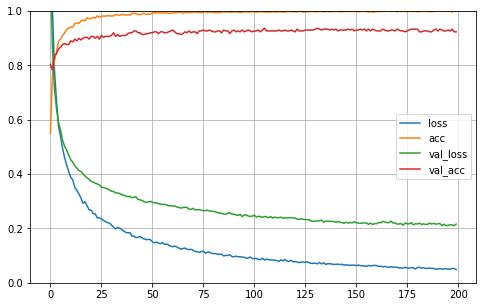

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.savefig('savefig_500dpi.png', dpi=500)

In [ ]:
y_proba = cnn.predict(X_test)
print("probability")
print(y_proba.round(2))


class_names = cat_encoder.categories_[0]
y_pred = np.argmax(y_proba,axis=1)
print()
print("predict")
print(class_names[y_pred])
print()
print("감정 개수 별 예측")
print(Counter(class_names[y_pred]))

probability
[[0.   0.   0.   0.   0.   1.  ]
 [0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.  ]
 ...
 [0.99 0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.  ]
 [0.   0.99 0.   0.   0.   0.  ]]

predict
['surprised' 'fear' 'happy' 'angry' 'sad' 'angry' 'fear' 'fear' 'fear'
 'disgust' 'fear' 'disgust' 'surprised' 'angry' 'happy' 'fear' 'fear'
 'happy' 'happy' 'happy' 'fear' 'angry' 'happy' 'disgust' 'surprised'
 'happy' 'surprised' 'fear' 'fear' 'happy' 'fear' 'surprised' 'sad'
 'disgust' 'sad' 'surprised' 'fear' 'surprised' 'disgust' 'sad'
 'surprised' 'sad' 'angry' 'fear' 'fear' 'sad' 'happy' 'angry' 'sad'
 'fear' 'fear' 'sad' 'fear' 'happy' 'sad' 'disgust' 'happy' 'happy'
 'happy' 'fear' 'happy' 'surprised' 'fear' 'sad' 'sad' 'disgust' 'sad'
 'angry' 'disgust' 'sad' 'sad' 'angry' 'sad' 'fear' 'happy' 'sad'
 'surprised' 'disgust' 'fear' 'angry' 'disgust' 'sad' 'surprised' 'fear'
 'disgust' 'sad' 'happy' 'surprised' 'fear' 'sad' 'fear' 'sad' 'surprised'
 'surprise

---

# Alpha
## 함수형 API

In [ ]:
vocab_size, embedding_dim = embedding_matrix.shape


# functional
sequence_length = X_train.shape[1]
inputs = tf.keras.layers.Input(shape=(max_sequence_length,))
embedding = tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM,
                                   weights=[embedding_matrix],
                                   trainable=True)(inputs)
reshape = tf.keras.layers.Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = tf.keras.layers.Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l2(0.01))(reshape)
conv_1 = tf.keras.layers.Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l2(0.01))(reshape)
conv_2 = tf.keras.layers.Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM),activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l2(0.01))(reshape)

maxpool_0 = tf.keras.layers.MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), 
                                      strides=(1,1))(conv_0)
maxpool_1 = tf.keras.layers.MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), 
                                      strides=(1,1))(conv_1)
maxpool_2 = tf.keras.layers.MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), 
                                      strides=(1,1))(conv_2)

# pool_outputs = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
pool_outputs = tf.keras.layers.Concatenate()([maxpool_0, maxpool_1, maxpool_2])

flatten = tf.keras.layers.Flatten()(pool_outputs)
dropout = tf.keras.layers.Dropout(drop_prob)(flatten)
output = Dense(units=6, 
               activation='softmax',
               kernel_regularizer=tf.keras.regularizers.l2(0.01))(dropout)

# this creates a model that includes
model = tf.keras.Model(inputs, output)

NameError: ignored

# 2018ver

In [ ]:
def cnn_model(dropout):   
    # gpu 설정
    with K.tf.device('/gpu:0'):
        model_Conv2 = Sequential()        

        EMBEDDING_DIM = 300
        MAX_SEQUENCE_LENGTH = 20
        
        # 3 Conv1D layers
        model_Conv2.add(Embedding(len(word_index),
                        EMBEDDING_DIM,
                        weights = [embedding_matrix],
                        input_length = MAX_SEQUENCE_LENGTH,
                        trainable = False) )
        
        model_Conv2.add(Conv1D(256,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv2.add(Dropout(dropout))
        
        model_Conv2.add(Conv1D(256,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv2.add(Dropout(dropout))
        
        model_Conv2.add(Conv1D(256,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv2.add(Dropout(dropout))

        model_Conv2.add(GlobalMaxPooling1D())
        
        model_Conv2.add(Dense(256, activation='relu'))
        model_Conv2.add(Dropout(dropout))
        
        model_Conv2.add(Dense(64, activation='relu'))
        model_Conv2.add(Dropout(dropout))

        model_Conv2.add(Dense(6, activation='softmax'))
        
        # optimizer 사용
        Adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
        
        model_Conv2.compile(
            loss = 'categorical_crossentropy',
            optimizer = Adam,
            metrics = ['accuracy'])
        
        model_Conv2.summary()
        # Model 학습, tensorflow chart 활용
        # tb_hist = tf.keras.callbacks.TensorBoard(log_dir = './graph', histogram_freq = 0, 
        #                                           write_graph = True, write_images = True)
        conv_model2 = model_Conv2.fit(
            X_train, y_train,
            epochs = 200, batch_size = 64,
            validation_split = 0.1,#0.1로 고정할 것
            callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10)], # tb_hist
            verbose = 1,
            shuffle=True)

        # final evaluation of the model
        print ("")
        scores = model_Conv2.evaluate(X_test, y_test, verbose=1)
        print ("")
        print ("loss: %.2f%%" % (scores[0] * 100))
        print ("Accuracy: %.2f%%" % (scores[1] * 100))

        # 과정 살펴보기
        matplotlib.rcParams.update({'font.size': 12})
        fig, loss_ax = plt.subplots()
        #krkwplt.style.use("ggplot")
        acc_ax = loss_ax.twinx()

        loss_ax.plot(conv_model2.history['loss'], 'y', label= 'train loss')
        loss_ax.plot(conv_model2.history['val_loss'], 'r', label= 'val loss')

        acc_ax.plot(conv_model2.history['accuracy'], 'b', label = 'train acc')
        acc_ax.plot(conv_model2.history['val_accuracy'], 'g', label = 'val acc')

        loss_ax.set_xlabel('epoch')
        loss_ax.set_ylabel('loss')
        acc_ax.set_ylabel('accuracy')

        loss_ax.legend(loc='right')
        acc_ax.legend(loc='best')
        fig = plt.gcf()
        plt.title("CNN Model")
        plt.show()
        
        return model_Conv2

In [ ]:
# cnn_model(X_train)
cnn_model(word2vec_path)